# Value Iteration RL

- Start with a state-value function $v_0(s)$
- Iteratively:
    - Find the optimal state-value function by iteratively using the Bellman's optimality equation:
    
$$ v_{k+1}(s) \leftarrow \max_{a \in \mathcal{A}} \left( \mathcal{R}^a_s + \gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{ss^{\prime}}^{a} v_k(s^{\prime}) \right) $$

      Or, in vector notation:
      
$$ \mathbf{v}_{k+1} \leftarrow \max_{a \in \mathcal{A}} \left( \mathcal{R}^a + \gamma \mathcal{P}^{a} \mathbf{v}_k \right), \; \mathcal{R}^a = \left[\mathcal{R}^a_s\right] \in \mathbb{R}^{\left| \mathcal{S} \right|}, \; \mathcal{P}^a = \left[\mathcal{P}^a_{ss^{\prime}}\right] \in \mathbb{R}^{\left| \mathcal{S} \right| \times \left| \mathcal{S} \right|} $$

      We should only stop when:
      
$$\left| v_{k+1}(s) - v_k(s) \right| < \epsilon, \; \forall s \in \mathcal{S}$$

- Finally, after we have discovered the optimal state-value function, we can derive from it the optimal action-value function, from which we can derive the optimal policy:

$$ \pi_{\star}(s) = \mathop{\mathrm{argmax}}_{a \in \mathcal{A}} q_{\star}(s, a) $$

$$ q_{\star}(s, a) = \mathcal{R}^a_s + \gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}^{a}_{ss^{\prime}} v_{\star}(s^{\prime}) $$

    Or, once again in vector notation:
    
$$ \pi_{\star} = \mathop{\mathrm{argmax}}_{a \in \mathcal{A}} \left( \mathcal{R}^a + \gamma \mathcal{P}^a \mathbf{v}_{\star} \right) $$

# Grid-World Problem

Let's define a simple problem so that we can apply the above algorithm. 

This is a simple grid-world, where we want to reach any of the corner squares (the goal). We are allowed to move either up, down, left or right, and every state has a reward of $-1$, except of the goal states which have a $0$ reward, regardless of the action taken. Whenever a move is made that would move the player out of the grid, the player maintains its position.

Translating this problem into our **Markov Decision Process** $\mathcal{M} = \langle \mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \gamma\rangle$:
- $\mathcal{S}$ is the set of all squares
- $\mathcal{A} = \{\mathtt{up}, \mathtt{down}, \mathtt{left}, \mathtt{right}\}$ if we are not in a goal state, otherwise $\mathcal{A} = \{\}$
- $\mathcal{P}$ is either 1 or 0 given the action and the two states, as this world is fully deterministic
- $\mathcal{R}^a_s = -1, \forall a \in \mathcal{A}$ if $s$ is not a goal state, otherwise $\mathcal{R}^a_s = 0$
- The discount factor $\gamma \in \left[0,1\right]$

## A Grid World Class

In [1]:
class GridWorldMDP:
    
    def __init__(self, rows, columns, discount):   
        # Auxiliary variables
        self.rows = rows
        self.columns = columns
        
        # MDP Tuple
        self.states = [(i,j) for i in range(rows) for j in range(columns)]
        self.actions = ["up", "down", "left", "right"]
        self.probabilities = self.generate_probabilities(self.states, self.actions)
        self.rewards = self.generate_rewards(self.states)
        self.discount = discount
        
    def get_discount(self):
        return self.discount
        
    def get_states(self):
        return self.states
    
    def get_actions(self):
        return self.actions
    
    def get_reward(self, state):
        return self.rewards[state]
    
    def get_probability(self, action, state1, state2):
        if (action, state1, state2) in self.probabilities:
            r = self.probabilities[(action, state1, state2)]
        else:
            r = 0
        
        return r
        
    def is_goal_state(self, state):
        # Get row and column from state
        i, j = state
        
        # Each of the possible goal states
        upper_left = (i == 0) and (j == 0)
        upper_right = (i == 0) and (j == self.columns-1)
        lower_left = (i == self.rows - 1) and (j == 0)
        lower_right = (i == self.rows - 1) and (j == self.columns - 1)
        
        return upper_left or upper_right or lower_left or lower_right
    
    def get_next_state(self, state, action):
        i, j = state
        
        # Change state according to action
        if action == "up":
            i_, j_ = max(0, i-1), j
        elif action == "down":
            i_, j_ = min(self.rows-1, i+1), j
        elif action == "left":
            i_, j_ = i, max(0, j-1)
        elif action == "right":
            i_, j_ = i, min(self.columns-1, j+1)
            
        return (i_, j_)
    
    def get_sucessor_states(self, state):
        if self.is_goal_state(state):
            s = []
        else:
            s = [self.get_next_state(state, action) for action in self.actions]
        return s
    
    def generate_probabilities(self, states, actions):
        # Populate only the possible transitions and its probabilities
        p = {}
        
        # For each state, populate only the adjacent states with probability 1
        for state in states:
            if not self.is_goal_state(state):
                for action in actions:
                    state_ = self.get_next_state(state, action)
                    p[(action, state, state_)] = 1
                
        return p
        
    def generate_rewards(self, states):
        r = {}
        
        # Populate the probabilities dictionary
        for state in states:
            if self.is_goal_state(state): r[state] = 0
            else: r[state] = -1
                
        return r

## A Value Iteration Solver

In [70]:
class VISolver:
    
    def __init__(self, MDP):
        # Store the MDP
        self.MDP = MDP
        
        # Initialize state-value function
        self.state_values = {state: 0.0 for state in self.MDP.get_states()}
        
    def update_state_values(self):
        # Initialize dictionary of state-values
        state_values = {}
        
        # Populate each state with their state-values
        gamma = self.MDP.get_discount()
        actions = self.MDP.get_actions()
        for state in self.MDP.get_states():
            state_values[state] = []
            
            # For each state calculate state-values for every action
            for action in actions:
                r = self.MDP.get_reward(state)
                state_ = self.MDP.get_next_state(state, action)
                
                # Iterate successor states
                p = self.MDP.get_probability(action, state, state_)
                r += gamma * p * self.state_values[state_]
                
                # Append state value of this action to this state
                state_values[state].append(r)
            
            # Choose maximum state-value as the state value for this state
            state_values[state] = max(state_values[state])
            
        # Get the maximum difference between the previous and current state values
        prev_sv = list(self.state_values.values())
        curr_sv = list(state_values.values())
        eps = max([abs(cs - pv) for (cs, pv) in zip(curr_sv, prev_sv)])
        
        # Replace the current state values
        self.state_values = state_values
        
        return eps
    
    def get_policy(self):
        # 1st: Calculate optimal action-value function
        
        # Get all actions and states and gamma
        actions = self.MDP.get_actions()
        states = self.MDP.get_states()
        gamma = self.MDP.get_discount()
        
        # Populate action-value function dictionary
        policy, q = {}, {}
        for state in states:
            q[state] = {}
            for action in actions:
                # Get reward of current state
                r = self.MDP.get_reward(state)
                state_ = self.MDP.get_next_state(state, action)
                
                # Add the next state expected reward
                p = self.MDP.get_probability(action, state, state_)
                r += gamma * p * self.state_values[state_]
                
                # Add to the action-value function
                q[state][action] = r
                
            # Get best action (key of q[state]) for this state and add to policy
            policy[state] = max(q[state], key=q[state].get)
            
        return policy
    
    def fit(self, eps=1e-3):
        # Define initial epsilon value
        eps_ = eps
        
        # Calculate optimal state values according to precision
        i = 0
        while eps_ >= eps:
            eps_ = self.update_state_values()
            i += 1
            print(f"-> Step {i} - Target precision: {eps:.3f} | Current precision: {eps_:.3f}")
            
        # Get the optimal policy from the optimal state-value function
        return self.get_policy()

## Apply the value iteration solver algorithm to get the optimal policy


In [71]:
# Define program hyperparameters
rows = 20
columns = 20
discount = 0.9
eps = 0.1

# Create Markov Decision Process of the GridWorld
MDP = GridWorldMDP(rows, columns, discount)

# Create a solver and find optimal policy
Solver = VISolver(MDP)
optimal_policy = Solver.fit(eps)

-> Step 1 - Target precision: 0.100 | Current precision: 1.000
-> Step 2 - Target precision: 0.100 | Current precision: 0.900
-> Step 3 - Target precision: 0.100 | Current precision: 0.810
-> Step 4 - Target precision: 0.100 | Current precision: 0.729
-> Step 5 - Target precision: 0.100 | Current precision: 0.656
-> Step 6 - Target precision: 0.100 | Current precision: 0.590
-> Step 7 - Target precision: 0.100 | Current precision: 0.531
-> Step 8 - Target precision: 0.100 | Current precision: 0.478
-> Step 9 - Target precision: 0.100 | Current precision: 0.430
-> Step 10 - Target precision: 0.100 | Current precision: 0.387
-> Step 11 - Target precision: 0.100 | Current precision: 0.349
-> Step 12 - Target precision: 0.100 | Current precision: 0.314
-> Step 13 - Target precision: 0.100 | Current precision: 0.282
-> Step 14 - Target precision: 0.100 | Current precision: 0.254
-> Step 15 - Target precision: 0.100 | Current precision: 0.229
-> Step 16 - Target precision: 0.100 | Current pr

## Visualize the optimal policy

In [64]:
%config InlineBackend.figure_format = "svg"
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

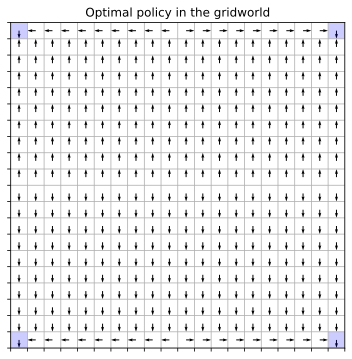

In [65]:
def action_to_angle(action):
    """
    Transforms an action into an arrow angle.
    Up and down are flipped because mpl grid is inverted compared to the MDP Grid-World.
    """
    if action == "up":
        r = - np.pi / 2
    elif action == "down":
        r = np.pi / 2
    elif action == "left":
        r = np.pi
    elif action == "right":
        r = 0
    
    return r

# Initialize array of lenghts and rotations of the arrows
r = 0.5 * np.ones((rows, columns))
theta = np.zeros((rows, columns))

# Populate array of angles according to optimal policy
for state in optimal_policy:
    i, j = state
    theta[i,j] = action_to_angle(optimal_policy[state])
    
# Transform to x and y coordinates
x, y = r * np.cos(theta), r * np.sin(theta)

# Plot the grid-world
ratio = rows / columns
fig = plt.figure(figsize=(6, 6 * ratio))
ax = fig.add_subplot(111)
ax.set_title("Optimal policy in the gridworld")
ax.quiver(x, y, scale_units="xy", scale=1, angles="xy")
ax.set_xlim(-0.5, columns-0.5)
ax.set_ylim(-0.5, rows-0.5)
ax.set_xticks([i - 0.5 for i in range(columns+1)])
ax.set_yticks([i - 0.5 for i in range(rows+1)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()

# Add rectangles for goals
rects = [(-0.5, -0.5, 1, 1), (-0.5, rows - 1.5, 1, 1), (columns - 1.5, -0.5, 1, 1), (columns - 1.5, rows - 1.5, 1, 1)]
for left, bottom, width, height in rects:
    rect=mpatches.Rectangle((left,bottom), width, height, alpha=0.2, facecolor="blue")
    ax.add_patch(rect)

plt.show()